In [6]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-ibm-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.1 MB/s eta 0:00:00


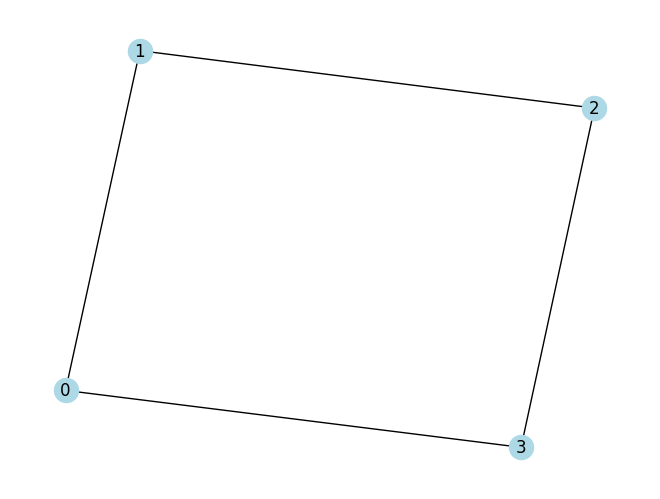

Parámetros óptimos: [1.97474131 2.72539735]
Valor final del costo: 3.029296875


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

# --- Definir el grafo ---
graph = nx.Graph([(0,1),(1,2),(2,3),(3,0)])
nx.draw(graph, with_labels=True, node_color='lightblue')
plt.show()

n_qubits = len(graph.nodes)

# --- Construir circuito QAOA ---
def qaoa_circuit(params):
    gamma, beta = params
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # estado inicial
    # capa de costo
    for i,j in graph.edges:
        qc.cx(i,j)
        qc.rz(2*gamma,j)
        qc.cx(i,j)
    # capa de mixer
    qc.rx(2*beta, range(n_qubits))
    qc.measure_all()
    return qc

# --- Función de costo usando AerSimulator ---
simulator = AerSimulator()

def cost_function(params):
    qc = qaoa_circuit(params)
    t_qc = transpile(qc, simulator)
    job = simulator.run(t_qc, shots=1024)
    result = job.result()
    counts = result.get_counts()
    cost = 0
    for bitstring, c in counts.items():
        z = np.array([1 if b=='0' else -1 for b in bitstring])
        s = sum(0.5*(1 - z[i]*z[j]) for i,j in graph.edges)
        cost += s * c / 1024
    return -cost  # minimizar para SciPy

# --- Optimización ---
np.random.seed(42)
params0 = np.random.uniform(0, np.pi, 2)
result = minimize(cost_function, params0, method='COBYLA')

# --- Resultados ---
print("Parámetros óptimos:", result.x)
print("Valor final del costo:", -result.fun)

